## This is a notebook for the validation of GBA-centrality-PR

It consists of four parts:
- **Part I: Leave-one-out validation**

    This is a comparison between the distribution of scores for left-out proteins with the distribution of scores for all proteins in the interactome. We compare the two distributions using a statistical test (Wilcoxon rank-sum) and calculate the p-value.

- **Part II: Tissue-enrichment validation**

    This is a comparison between the ratio of predicted causal proteins enriched in the tissue with the ratio of all proteins enriched in the tissue. We compare the two ratio using a statistical test (Fisher exact) and calculate the p-value to answer the question: "Are predicted causal genes significantly enriched in the tissue-specific genes?".

- **Part III: Robustness**

    This is a comparison between the lists of top 10% of highest-scoring genes generated with the new interactome (19/09/2024) vs the old interactome (15/01/2024). We hypothesize that the method is robust, therefore the two lists should be similar, even though the interactomes differ in the number of proteins and interactions. To determine the ovelap between the two lists, we compare then lists with a statistical test (Wilcoxon rank-sum) and calculate the p-value.

- **Part IV: Benchmark against other centralities**

- **Part V: Average distance between causal and predicted causal proteins**

In [1]:
import sys

import scipy
import numpy

import networkx

import matplotlib.pyplot
import matplotlib_venn

sys.path.append("../scripts")
import utils

In [2]:
def parse_scores(scores_file):
    '''
    Loads the scores generated with GBA_centrality_PR.py
    Returns a dictionary: key=ENSG, value=score
    '''
    results = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results[ENSG] = float(score)

    return results

In [3]:
def parse_leave_one_out(leave_one_out_file):
    '''
    Loads the scores for left-out proteins generated with leave_one_out.py
    Returns a dictionary: key=ENSG, value=score
    '''
    results_left_out = {}

    with open(leave_one_out_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            results_left_out[ENSG] = float(score)
        
    return results_left_out

In [4]:
def geneName_to_ENSG(genes_file):
    '''
    Loads a TSV file with columns: geneName\tENSG
    Returns a dictionary: key=geneName, value=ENSG
    '''
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

In [5]:
def ENSG_to_geneName(genes_file):
    '''
    Loads a TSV file with columns: geneName\tENSG
    Returns a dictionary: key=ENSG, value=geneName
    '''
    ENSGs = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        ENSGs[ENSG] = gene_name
    
    return ENSGs

In [6]:
def parse_expression_data(expression_data, interactome):
    '''
    Loads a TSV file with columns: ENSG\tgene_expression_ratio
    Returns a dictionary: key=ENSG, value=gene_expression_ratio
    '''
    tissue_expression = {}

    with open(expression_data) as f:
        # skip header
        for _ in range(5):
            next(f)
        for line in f:
            split_line = line.rstrip().split('\t')

            ENSG, tissue_ratio, *_ = split_line

            if ENSG in interactome.nodes():
                tissue_expression[ENSG] = float(tissue_ratio)
    
    return tissue_expression

In [7]:
def intersection(list_1, list_2):
    '''
    Returns a list with common elements for two lists
    '''
    return list(set(list_1) & set(list_2))

In [8]:
def take_top_percent(list, x):
    '''
    Finds the top x% of values in a list
    Returns: 
    - top: list with top x% of values
    - rest list with the rest of values
    '''
    num_elements = int(len(list) * x/100)
    num_elements = max(num_elements, 1)

    top = list[:num_elements]
    rest = list[num_elements:]
    
    return top, rest

In [9]:
def format_pvalue(pvalue):
    '''Returns the p-value in the notation: "1.00e-2**" '''
    p = '{:.2e}'.format(pvalue)

    if pvalue <= 0.0001:
        return p + "****"
    elif pvalue <= 0.001:
        return p + "***"
    elif pvalue <= 0.01:
        return p + "**"
    elif pvalue <= 0.05:
        return p + "*"    
    return p + ""

### Set parameters and paths

In [163]:
'''Set parameters with which the GBA_centrality_PR.py was run'''
PHENOTYPE = "MMAF" # to choose from: MMAF, NOA, DILCARD, HYPCARD, BC (breast cancer), CC (colon cancer)
ALPHA = 0.5
alpha = str(ALPHA).replace('.', '')
D_MAX = 10

In [164]:
INTERACTOME_PATH = "../input/Interactome_human.sif"
CANONICAL_GENES_PATH = "../input/canonicalGenes.tsv"

RESULTS_PATH = f"../../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores.tsv"
LEAVE_ONE_OUT_PATH = f"../../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores_leave_one_out.tsv"

In [165]:
'''Data and parameters for Part II: Tissue-enrichment validation'''
PRED_CAUSAL_DEF = 10 # [%]
TISSUE_ENRICHED_DEF = 10 # [%]

TISSUE = "testis" # to choose from: testis, breast, colon, heart

GTEX_DATA_PATH = f"E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.tsv"

In [166]:
'''Data and parameters for Part III: Robustness'''
INTERACTOME_OLD_PATH = "../input/Interactome_human_15012024.sif"
RESULTS_OLD_PATH = f"../../output/Interactome_human_15012024/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores.tsv"

In [189]:
'''Data for Part IV: '''
CAUSAL_GENES_PATH = "/home/kubicaj/workspace/Interactome-TIMC/input/causalGenes_infertility.tsv"

In [190]:
'''Set path for output figures'''
FIGURES_DIR = "/home/kubicaj/workspace/Interactome-TIMC/dev/figures/"

### Load data

In [169]:
'''Parse interactome'''
interactome = utils.parse_interactome(interactome_file=INTERACTOME_PATH)
print(f"proteins: {len(interactome.nodes())}, interactions: {len(interactome.edges())}")

proteins: 14735, interactions: 91526


In [191]:
(ENSG2gene, gene2ENSG) = utils.parse_gene2ENSG(gene2ENSG_file=CANONICAL_GENES_PATH)
causal_genes = utils.parse_causal_genes(causal_genes_file=CAUSAL_GENES_PATH, gene2ENSG=gene2ENSG, interactome=interactome, patho=PHENOTYPE)

gene LINC01505 mapped to multiple ENSGs, keeping the first == ENSG00000234229
gene ITFG2-AS1 mapped to multiple ENSGs, keeping the first == ENSG00000256150
gene LINC01238 mapped to multiple ENSGs, keeping the first == ENSG00000237940
gene GOLGA8M mapped to multiple ENSGs, keeping the first == ENSG00000188626
gene TMSB15B mapped to multiple ENSGs, keeping the first == ENSG00000158427
gene POLR2J4 mapped to multiple ENSGs, keeping the first == ENSG00000214783
gene MATR3 mapped to multiple ENSGs, keeping the first == ENSG00000015479
causal gene AK7 == ENSG00000140057 is not in interactome, skipping it
causal gene CCDC39 == ENSG00000145075 is not in interactome, skipping it
causal gene CFAP251 is not in gene2ENSG, skipping it
causal gene CFAP43 == ENSG00000197748 is not in interactome, skipping it
causal gene CFAP52 == ENSG00000166596 is not in interactome, skipping it
causal gene CFAP61 == ENSG00000089101 is not in interactome, skipping it
causal gene CFAP70 == ENSG00000156042 is not in i

In [196]:
'''Load GBA centrality scores and leave-one-out results, then sort them by descending scores'''
results = parse_scores(RESULTS_PATH)
results_leave_one_out = parse_leave_one_out(LEAVE_ONE_OUT_PATH)
# remove seed proteins from scores
for gene in results_leave_one_out:
    del results[gene]
    
results_sorted = sorted(results.keys(), key=lambda item: results[item], reverse=True)
scores_sorted = [results[node] for node in results_sorted]

results_leave_one_out_sorted = sorted(results_leave_one_out.keys(),
                                      key=lambda item: results_leave_one_out[item],
                                      reverse=True)
scores_leave_one_out_sorted = [results_leave_one_out[node] for node in results_leave_one_out_sorted]

In [197]:
'''Load data for conversions between gene names and ENSGs'''
ENSGs = ENSG_to_geneName(CANONICAL_GENES_PATH)
gene_names = geneName_to_ENSG(CANONICAL_GENES_PATH)

In [198]:
'''Load tissue expression from grexome-TIMC-Secondary-interactome/GTEX_Data'''
tissue_expr = parse_expression_data(GTEX_DATA_PATH, interactome=interactome)

In [199]:
'''Get top x high-scoring genes'''
for gene in results_sorted[:15]:
    print(ENSGs[gene])

CCDC66
C20orf96
CDX2
C9orf153
TPGS1
TYMP
PLEKHG1
ONECUT3
RTTN
LRRC40
GPATCH1
GEN1
CCDC18
C2CD3
TMEM209


### Part I: Leave-one-out validation

In [200]:
'''Check if the distribution of scores for left-out proteins is greater than
the distribution of scores for all proteins in the interactome'''
_, p_leave_one_out = scipy.stats.ranksums(scores_leave_one_out_sorted, 
                                          scores_sorted, 
                                          alternative='greater')

p_leave_one_out = format_pvalue(p_leave_one_out)
print(f"p-value = {p_leave_one_out}")

p-value = 3.68e-03**


Text(1.3, 0.0085, 'p=3.68e-03**')

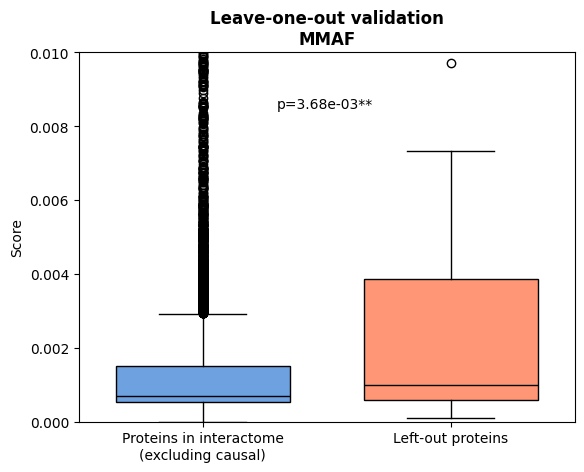

In [175]:
fig, ax = matplotlib.pyplot.subplots()
labels = ["Proteins in interactome\n(excluding causal)", "Left-out proteins"]
colors = ["#6DA1E0", "#FF9776"]


plot = ax.boxplot([scores_sorted, scores_leave_one_out_sorted],
                   widths=0.7,
                   patch_artist=True,
                   tick_labels=labels)

# fill with colors
for patch, color in zip(plot['boxes'], colors):
    patch.set_facecolor(color)

for median in plot['medians']:
    median.set_color('black')

matplotlib.pyplot.title(f"Leave-one-out validation\n{PHENOTYPE}",
                        weight='bold',
                        fontsize=12)
matplotlib.pyplot.ylabel("Score")
matplotlib.pyplot.xlabel("")

ylim = 0.01
matplotlib.pyplot.ylim(0, ylim)
matplotlib.pyplot.text(x=1.3,y=ylim*0.85, s=f"p={p_leave_one_out}")

# save figure for publication
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_leave_one_out", dpi=1000)

### Part II: Tissue-enrichment validation

In [176]:
'''Get top x% of highest-scoring genes'''
pred_causal, non_pred_causal = take_top_percent(results_sorted, PRED_CAUSAL_DEF)

In [177]:
'''Get top x% of genes expressed in the tissue'''
tissue_expr_sorted = sorted(tissue_expr.keys(), key=lambda item: tissue_expr[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top_percent(tissue_expr_sorted, TISSUE_ENRICHED_DEF)

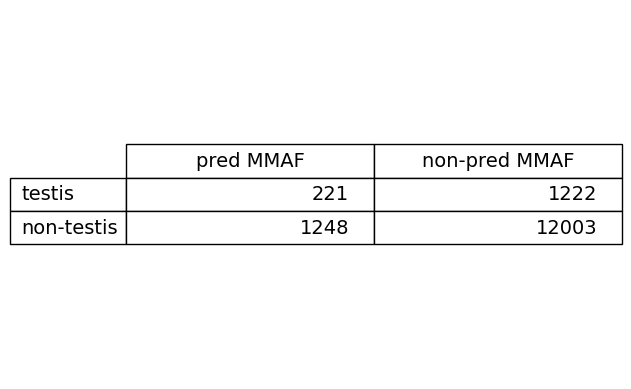

In [178]:
'''Construct a contingency matrix for the statistical test'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [179]:
''' 
Check if the ratio of predicted causal proteins enriched in the tissue is greater 
than the ratio of all proteins enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"p-value = {p_tissue_expr}")

p-value = 1.43e-11****


Text(0, 0.5, 'Ratio')

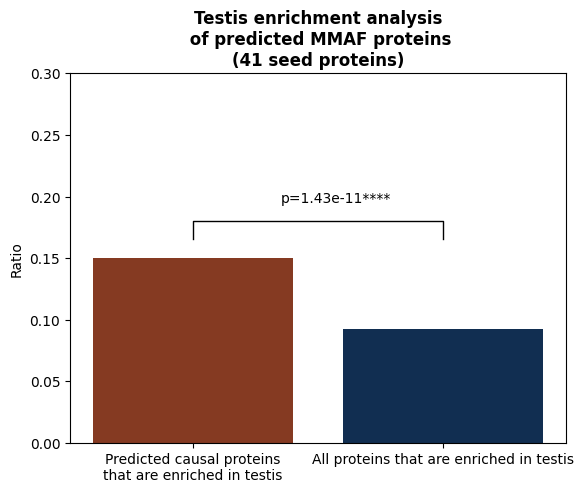

In [180]:
proportion1 = x1 / (x1 + x3) # ratio of predicted causal genes that are tissue-enriched
proportion2 = x2 / (x2 + x4) # ratio of all genes that are tissue-enriched

labels = [f"Predicted causal proteins\nthat are enriched in {TISSUE}", 
          f"All proteins that are enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])
matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} proteins\n({len(results_leave_one_out)} seed proteins)", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"p={p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment", dpi=1000)

### Part III: Robustness

In [181]:
'''Parse the old interactome'''
interactome_old = utils.parse_interactome(interactome_file=INTERACTOME_OLD_PATH)
print(f"proteins: {len(interactome_old.nodes())}, interactions: {len(interactome_old.edges())}")

proteins: 14393, interactions: 89319


In [182]:
'''Load GBA centrality scores for the old interactome, then sort them by descending scores'''
results_old = parse_scores(RESULTS_OLD_PATH)

results_old_sorted = sorted(results_old.keys(), key=lambda item: results_old[item], reverse=True)
scores_old_sorted = [results_old[node] for node in results_old_sorted]

In [183]:
'''Get top x% of highest-scoring genes'''
pred_causal_old, _ = take_top_percent(results_old_sorted, PRED_CAUSAL_DEF)

In [184]:
'''Determine the ovelap between the two lists with a statistical test (Wilcoxon rank-sum) and calculate the p-value'''
_, p_overlap = scipy.stats.ranksums(pred_causal, pred_causal_old, alternative='two-sided')
p_overlap = format_pvalue(pvalue=p_overlap)
print(f"p-value = {p_overlap}")

p-value = 5.34e-01


Text(0.5, 1.0, 'Number of predicted MMAF proteins\n (old interactome vs new interactome)')

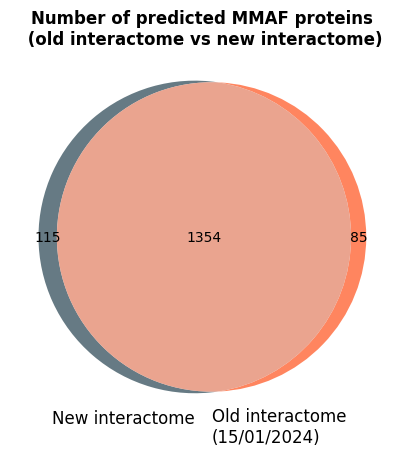

In [185]:
x1 = len(pred_causal) - len(intersection(pred_causal, pred_causal_old))
x2 = len(pred_causal_old) - len(intersection(pred_causal, pred_causal_old))
x3 =  len(intersection(pred_causal, pred_causal_old))

matplotlib_venn.venn2([x1, x2, x3], 
                      set_labels=("New interactome", "Old interactome\n(15/01/2024)"),
                      set_colors=("#4B636E", "#FF7043"), alpha=0.85)
matplotlib.pyplot.title(f"Number of predicted {PHENOTYPE} proteins\n (old interactome vs new interactome)", 
                        weight='bold',
                        fontsize=12)
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_robustness_causal{PRED_CAUSAL_DEF}perc", dpi=1000)

### Part IV: Benchmark against other centralities

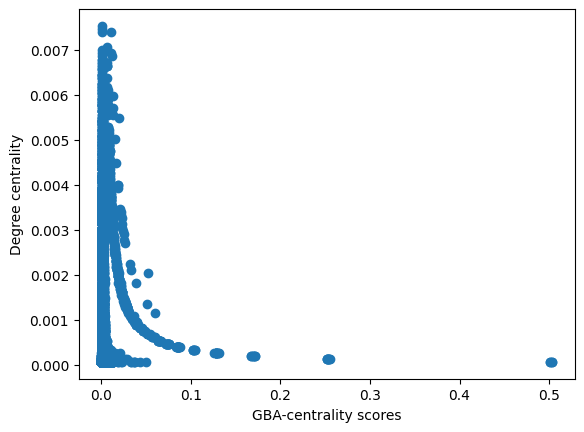

In [105]:
'''Degree centrality'''
degree_centrality = networkx.degree_centrality(interactome)

# order scores and degrees as in results.keys()
proteins = results.keys()
scores = [results[node] for node in proteins]
deg_c = [degree_centrality[node] for node in proteins]

matplotlib.pyplot.scatter(x=scores, y=deg_c)
matplotlib.pyplot.xlabel("GBA-centrality scores")
matplotlib.pyplot.ylabel("Degree centrality")
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_degree_centrality", dpi=1000)

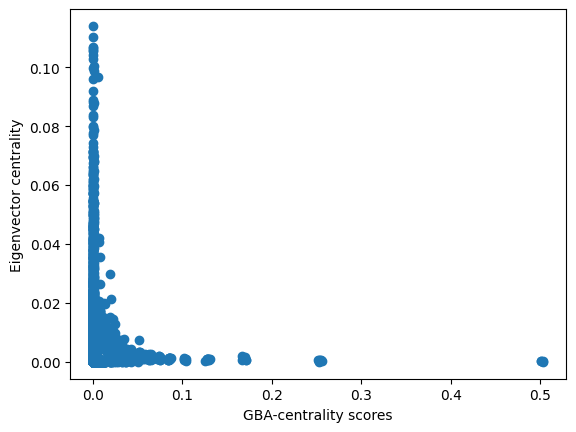

In [106]:
'''Eigenvector centrality'''
eigenvector_centrality = networkx.eigenvector_centrality_numpy(interactome)

# order scores and degrees as in results.keys()
proteins = results.keys()
scores = [results[node] for node in proteins]
eigenvec_c = [eigenvector_centrality[node] for node in proteins]

matplotlib.pyplot.scatter(x=scores, y=eigenvec_c)
matplotlib.pyplot.xlabel("GBA-centrality scores")
matplotlib.pyplot.ylabel("Eigenvector centrality")
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_eigenvector_centrality", dpi=1000)

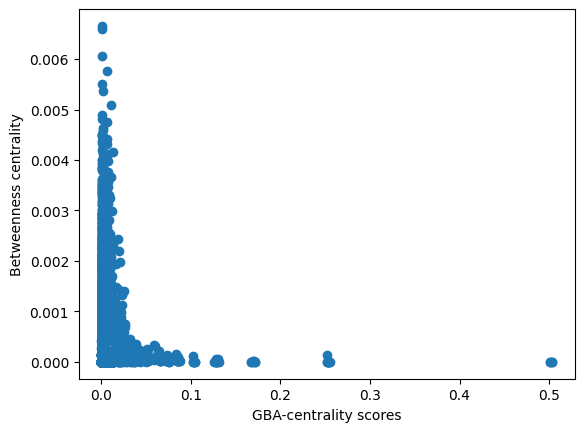

In [108]:
'''Betweenness centrality'''
betweenness_centrality = networkx.betweenness_centrality(interactome)

# order scores and degrees as in results.keys()
proteins = results.keys()
scores = [results[node] for node in proteins]
between_c = [betweenness_centrality[node] for node in proteins]

matplotlib.pyplot.scatter(x=scores, y=between_c)
matplotlib.pyplot.xlabel("GBA-centrality scores")
matplotlib.pyplot.ylabel("Betweenness centrality")
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_betweenness_centrality", dpi=1000)

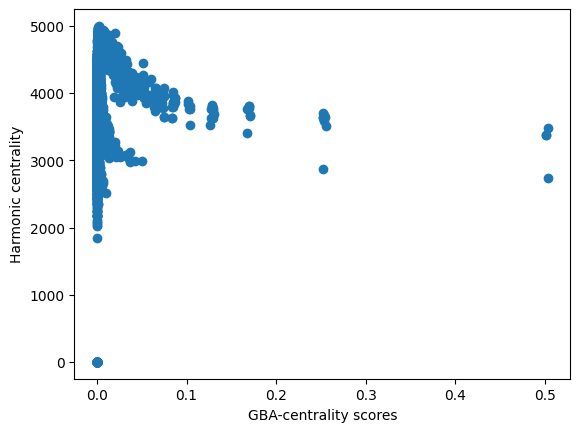

In [107]:
'''Harmonic centrality'''
harmonic_centrality = networkx.harmonic_centrality(interactome)

# order scores and degrees as in results.keys()
proteins = results.keys()
scores = [results[node] for node in proteins]
harmonic_c = [harmonic_centrality[node] for node in proteins]

matplotlib.pyplot.scatter(x=scores, y=harmonic_c)
matplotlib.pyplot.xlabel("GBA-centrality scores")
matplotlib.pyplot.ylabel("Harmonic centrality")
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_harmonic_centrality", dpi=1000)

gene LINC01505 mapped to multiple ENSGs, keeping the first == ENSG00000234229


gene ITFG2-AS1 mapped to multiple ENSGs, keeping the first == ENSG00000256150
gene LINC01238 mapped to multiple ENSGs, keeping the first == ENSG00000237940
gene GOLGA8M mapped to multiple ENSGs, keeping the first == ENSG00000188626
gene TMSB15B mapped to multiple ENSGs, keeping the first == ENSG00000158427
gene POLR2J4 mapped to multiple ENSGs, keeping the first == ENSG00000214783
gene MATR3 mapped to multiple ENSGs, keeping the first == ENSG00000015479
causal gene AK7 == ENSG00000140057 is not in interactome, skipping it
causal gene CCDC39 == ENSG00000145075 is not in interactome, skipping it
causal gene CFAP251 is not in gene2ENSG, skipping it
causal gene CFAP43 == ENSG00000197748 is not in interactome, skipping it
causal gene CFAP52 == ENSG00000166596 is not in interactome, skipping it
causal gene CFAP61 == ENSG00000089101 is not in interactome, skipping it
causal gene CFAP70 == ENSG00000156042 is not in interactome, skipping it
causal gene CFAP91 is not in gene2ENSG, skipping it
ca

Text(0, 0.5, 'Katz centrality')

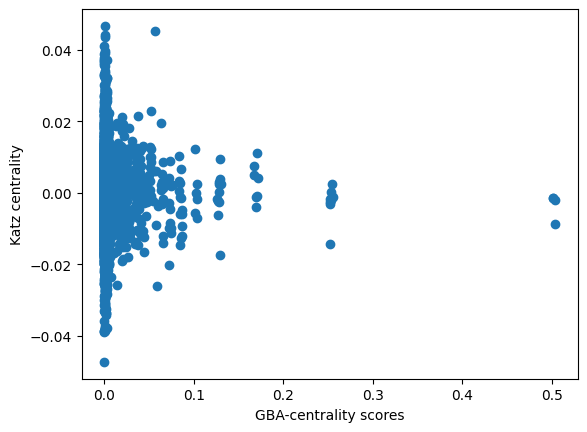

In [134]:
'''Katz centrality, alpha=0.5'''
beta = dict.fromkeys(interactome.nodes(), 0)

for causal in causal_genes:
    beta[causal] = 1


katz_centrality = networkx.katz_centrality_numpy(interactome, alpha=0.5, beta=beta)

# order scores and degrees as in results.keys()
proteins = results.keys()
scores = [results[node] for node in proteins]
katz_c = [katz_centrality[node] for node in proteins]

matplotlib.pyplot.scatter(x=scores, y=katz_c)
matplotlib.pyplot.xlabel("GBA-centrality scores")
matplotlib.pyplot.ylabel("Katz centrality")
# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_katz_centrality_alpha05", dpi=1000)

### Part V: Average distance between causal and predicted causal proteins

In [214]:
distances = []

for pred in pred_causal:
    for causal in causal_genes:
        dist = networkx.shortest_path_length(G=interactome, source=pred, target=causal)
        distances.append(dist)

avg_dist = sum(distances) / len(distances)

print(*distances)
print(avg_dist)

5 5 5 4 3 5 4 5 1 3 5 5 4 5 5 5 5 4 4 5 5 5 4 5 5 7 4 4 4 4 5 3 2 5 4 5 5 4 5 4 4 6 6 6 5 5 5 6 6 5 5 5 6 6 6 6 1 6 5 5 5 6 5 5 5 5 8 5 6 5 6 6 5 6 6 5 6 5 5 7 6 6 5 5 5 4 3 5 4 5 3 1 4 5 4 5 5 5 5 4 5 5 5 5 5 5 5 7 5 5 5 4 6 3 3 5 4 5 4 5 4 4 3 5 5 5 4 3 5 4 5 3 1 4 5 4 5 5 5 5 4 5 5 5 5 5 5 5 7 5 5 5 4 6 3 3 5 4 5 4 5 4 4 3 5 5 5 4 3 5 4 5 1 3 5 5 4 5 5 5 5 4 4 4 5 5 4 5 5 7 4 4 4 4 5 3 2 5 4 5 5 4 5 4 4 4 4 5 4 3 4 4 3 4 3 4 3 3 4 5 4 4 5 4 4 5 5 4 4 5 7 4 5 4 3 5 3 4 4 4 4 4 2 2 4 1 5 5 5 4 2 5 4 5 1 3 4 5 4 4 4 5 5 4 4 4 5 5 4 5 5 6 4 4 3 4 5 3 2 4 4 5 5 4 4 4 3 4 5 5 4 4 4 4 5 4 3 5 3 3 4 4 5 4 5 4 4 5 5 4 5 5 7 4 5 4 3 5 3 4 5 4 5 4 4 2 4 1 5 5 5 4 3 5 4 4 1 3 4 4 4 5 5 5 5 4 4 4 5 3 3 5 5 7 4 4 4 4 5 3 2 4 4 5 4 4 5 4 4 6 6 6 5 4 5 5 6 5 5 6 6 5 6 6 6 6 6 5 6 6 6 6 6 6 1 5 6 4 5 6 4 5 6 5 5 6 5 6 6 5 5 5 5 4 3 5 4 5 1 3 5 4 4 5 5 5 5 4 4 4 4 4 4 5 5 7 4 4 4 4 5 3 2 5 4 5 5 4 4 4 3 4 5 5 3 3 5 4 4 1 3 4 5 4 5 5 5 4 4 4 5 5 4 4 4 5 7 4 4 3 4 5 3 2 4 4 5 5 4 4 4 3 4 4 5 4 3 5 4 5 